# Matched Filtering Cross Correlation

Matched filtering detects events missed by traditional phase picking methods. A template from an event is slid across continuous waveform data to find similar events by calculating a correlation coefficient at an event.

This example of matched filtering cross correlation uses the following steps:

1. Find known events for the area of interest within a range of dates and store them in a catalog.
2. The type of events can be mixed, adding a known volcanic event will improve the probablity of finding volcanic tectonic events.
3. Create an inventory of stations around the area of interest. Select stations with high frequency vertical channels that capture near source ground motion.
4. For each station, create picks based on the catalog of events.
5. Create 10 second templates that capture P and S waves.
6. Find new events by running the templates over continuous waveforms.


## Import packages

In [210]:
import numpy as np
import eqcorrscan
import pandas as pd

from eqcorrscan import Tribe
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy.core.event import (
    Catalog, Event, Pick, WaveformStreamID, Origin)
from obspy.geodetics import gps2dist_azimuth

## Finding events

We can use obspy `get_events` to find events around Mount Saint Helens. We can search events within 0.25 km around Mount Saint Helens from 2014 to 2016 when the iMUSH data was collected.

In [211]:
client = Client("USGS")
catalog = client.get_events(
    starttime=UTCDateTime(2014, 5, 1),
    endtime=UTCDateTime(2016, 12, 31),
    latitude=46.2, longitude=-122.19,
    maxradius=0.25)

print(catalog.count())

1782


There are more than 1500 events in the iMUSH data. The obspy catalog object is a Python dictionary and we can list the attributes or keys in the catalog.

In [212]:
events = catalog[0].__dict__.keys()
for e in events:
    print(e)

resource_id
event_type
event_type_certainty
creation_info
preferred_origin_id
preferred_magnitude_id
preferred_focal_mechanism_id
event_descriptions
comments
picks
amplitudes
focal_mechanisms
origins
magnitudes
station_magnitudes
extra
_format


> **Explainer:**
>
> Object attributes can be listed using a special dictionary, `__dict__` that stores the attributes of an object.

Using the catalog attributes, we can examine the data by converting it to a pandas dataframe. The dataframe supports table operations for analyzing and displaying data.

In [213]:
df = pd.DataFrame([{
    'time': (event.preferred_origin() or event.origins[0]).time,
    'latitude': (event.preferred_origin() or event.origins[0]).latitude,
    'longitude': (event.preferred_origin() or event.origins[0]).longitude,
    'depth': (event.preferred_origin() or event.origins[0]).depth,
    'magnitude': (event.preferred_magnitude() or event.magnitudes[0]).mag if event.magnitudes else None
} for event in catalog])

display(df.head(10))

,time,latitude,longitude,depth,magnitude
0,2016-12-30T15:01:14.460000Z,46.200333,-122.178833,2800.0,0.18
1,2016-12-30T12:41:12.850000Z,46.206833,-122.190000,3330.0,1.11
2,2016-12-30T09:45:26.680000Z,46.198000,-122.182000,1390.0,0.63
3,2016-12-30T09:21:20.440000Z,46.195833,-122.182667,2320.0,0.55
4,2016-12-28T22:11:02.190000Z,46.203667,-122.186167,1140.0,0.29
5,2016-12-26T20:23:34.770000Z,46.204333,-122.182333,5710.0,0.21
6,2016-12-24T12:08:49.640000Z,46.212167,-122.180000,4290.0,0.00
7,2016-12-24T12:08:39.190000Z,46.205333,-122.169167,5220.0,-0.48
8,2016-12-24T03:06:20.280000Z,46.194167,-122.189000,2010.0,0.50
9,2016-12-22T17:11:09.160000Z,46.214333,-122.181833,4030.0,0.13


>**Explainer:**
>
>The event catalog is coverted to a pandas dataframe by accessing the catalog attributes. A dataframe canb display the catalog data in a table and supports operations such sorting, grouping, and calculating new values.
>
>`display` returns a formatted table, and `df.head(10)` shows only the first 10 events.

We want to find dates with a number of events. We can count the number of events per day by grouping them and sorting by by descending values.

In [214]:
from obspy import UTCDateTime
from datetime import datetime

# First, convert the 'time' column to datetime
# df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].apply(lambda x: x.datetime)

# Extract just the date (without time)
df['date'] = df['time'].dt.date

# After grouping and sorting
events_per_day = df.groupby('date').size().sort_values(ascending=False).head(5)

# Print all results
print(events_per_day)

date
2014-09-16    21
2014-07-25    20
2014-08-03    19
2015-04-15    15
2016-04-01    15
dtype: int64


>**Explainer:**
>
>Obspy uses UTCDateTime which is different from Python datetime. To work with dates in Python, UTCDateTime must be converted to a Python datetime object. In a dataframe, we can convert the entire `time` column with the `apply` method. The conversion uses a lambda, which is an inline function where x is the value to be converted by accessing the .datetime attribute of the ObsPy UTCDateTime object.
>
>To group events by date, a `date` column is created by extracting it from the `time` column.
>
>To count the events by day, we can use the `groupby` and `size` methods to count the number of occurrences by group, and display the top 5 days by the number of events per day.


We can use the date the with the greatest number of events to query the USGS server.

In [215]:
catalog = client.get_events(
    starttime=UTCDateTime(2014, 9, 16),
    endtime=UTCDateTime(2014, 9, 17),
    latitude=46.2, longitude=-122.19,
    maxradius=0.25)

print(catalog.count())

21


Events at volcanoes are difficult to locate, especially if they're small. If you don't have a known event, you'll never find them with template detection. [REDPy](https://code.usgs.gov/vsc/seis/tools/REDPy/) to find a known volcanic earthquake. We can take one event out of a family there to improve the probablity of finding like events.

The event triggered at 2014-07-25T16:57:57.08. There isn't a location, so we will assume it's near the summit at a depth of about 2 km b.s.l.

In [216]:
event_solo = Event()
event_solo.origins = [Origin()]
event_solo.origins[0].time = UTCDateTime('2014-07-25T16:57:57.08') - 2  # assume about 2 seconds from origin to trigger time
event_solo.origins[0].latitude = 46.2
event_solo.origins[0].longitude = -122.19
event_solo.origins[0].depth = 2000

# Append to the catalog
catalog += event_solo

print(catalog.count())

22


>**Explainer**
>
>An event is created using the time of a known volcanic earthquake along with the location and depth. The event is added to the previous event catalog.

We can examine the events in the catalog.

In [217]:
print(catalog.__str__(print_all=True))

22 Event(s) in Catalog:
2014-09-16T23:44:48.730000Z | +46.199, -122.185 | 0.09 ml | manual
2014-09-16T22:59:39.860000Z | +46.136, -122.166 | -0.25 md | manual
2014-09-16T22:23:59.700000Z | +46.335, -122.364 | 0.17 ml | manual
2014-09-16T22:23:37.110000Z | +46.348, -122.381 | 0.86 ml | manual
2014-09-16T21:19:35.630000Z | +46.199, -122.182 | 0.25 ml | manual
2014-09-16T20:15:11.090000Z | +46.315, -122.332 | 0.16 ml | manual
2014-09-16T19:52:58.110000Z | +46.314, -122.353 | 0.6  ml | manual
2014-09-16T19:06:56.970000Z | +46.197, -122.185 | 0.14 ml | manual
2014-09-16T18:55:25.150000Z | +46.333, -122.364 | 0.19 ml | manual
2014-09-16T18:51:18.680000Z | +46.347, -122.392 | 1.56 ml | manual
2014-09-16T18:38:34.830000Z | +46.200, -122.181 | 0.27 ml | manual
2014-09-16T18:31:10.190000Z | +46.198, -122.179 | 0.56 ml | manual
2014-09-16T14:15:22.750000Z | +46.301, -122.359 | -0.08 md | manual
2014-09-16T12:53:36.550000Z | +46.311, -122.347 | 0.06 md | manual
2014-09-16T12:53:02.880000Z | +46.31

## Make templates

Unfortunately, pick information for these earthquakes is not available. We can make a very rough estimate of the P-wave arrival time at the stations of interest and use that as the start of our template window. In a large relative relocation study, you'd work with actual pick times and shorter windows around P- and S-, but for this example, this is a good starting point if you're looking to find more events.

### Get Stations near Mount Saint Helens

The first step is to get an inventory of stations withing 0.25 km around the Mount Saint Helens summit. Volcanic earthquakes are typically weak motion, high frequency events, we're interest in high gain, vertical motion channels (*HZ).

In [218]:
client = Client("IRIS")
inventory = client.get_stations(starttime=UTCDateTime(2015, 7, 1),
    endtime=UTCDateTime(2015, 12, 31),
    latitude=46.2, longitude=-122.19,
    maxradius=0.25, channel='*HZ', level='channel')

print(f"Stations found: {len(inventory)}")
channel_count = 0
for network in inventory:
    for station in network:
        for channel in station:
            channel_count += 1

print(f"Total Channels Found: {channel_count}")

Stations found: 4
Total Channels Found: 105


>**Explainer:**
>
>The obspy `get_stations` method is used to retrieve stations with a *HZ channel.

### Create Picks

Loop over events and create picks for each channel based on distance of the station from source and a basic assumption of 5 km/s wave speed. This is a rough first pass.

In [219]:
p_vel = 5000  # m/s 
for event in catalog:
    picks = []
    for channel in inventory.get_contents()['channels']:
        # XD (iMUSH deployment) broadbands have LHZ, BHZ, and HHZ channels; we only need HHZ
        if channel[:2] != 'XD' or (channel[:2] == 'XD' and channel[-3:] == 'HHZ'):
            distance = np.sqrt(gps2dist_azimuth(
                event.origins[0].latitude,
                event.origins[0].longitude,
                inventory.get_channel_metadata(channel)['latitude'],
                inventory.get_channel_metadata(channel)['longitude']
            )[0]**2 + (event.origins[0].depth + inventory.get_channel_metadata(channel)['elevation'])**2)
            picks += [
                Pick(
                    time=event.origins[0].time +  distance/p_vel,
                    waveform_id=WaveformStreamID(
                        network_code=channel.split('.')[0],
                        station_code=channel.split('.')[1],
                        channel_code=channel.split('.')[3],
                        location_code=channel.split('.')[2],
                    ),
                    phase_hint='P'
                )
            ]
    event.picks = picks
print(len(event.picks))

53


/Users/sophiaparafina/miniconda3/envs/ssa_prototype/lib/python3.13/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


>**Explainer:**
>
>The code iterates through each event in a seismic catalog and generates synthetic P-wave arrival time picks for all available stations by calculating the travel time from each event's origin to each station. The 3D hypocentral distance between the event's origin location (latitude, longitude, depth) and the station's location (latitude, longitude, elevation) is calculated using the Pythagorean theorem on both the horizontal surface distance (calculated via gps2dist_azimuth) and the vertical depth difference.
>
>Using this distance and an assumed P-wave velocity (p_vel), it calculates the expected P-wave arrival time by adding the travel time (distance/velocity) to the event's origin time. It creates a Pick object with this synthetic arrival time and the channel's metadata (network, station, location, and channel codes extracted by splitting the dot-separated channel string) and marks it as a P-wave phase. It assigns the synthetic picks back to the event object, creating a theoretical pick catalog that assumes P-waves travel at a constant velocity.

### Create Templates

Eqcorrscan is a Python package for the detection and analysis of repeating and near-repeating seismicity. EQcorrscan provides a multi-parallel, matched-filter detection routine (template-matching).

We're constructing templates with a 10-second window to capture P and S with a bit of filtering. These can all be adjusted but should match the filtering and processing length you plan to use to scan through the continuous data. 

In matched filtering, a tribe is a collection of template waveforms that are used together to scan continuous seismic data for similar events. It is a container object (from the EQcorrscan library) that holds multiple Template objects. Each template represents a known seismic event's waveform pattern.

In [220]:
tribe = Tribe().construct(
    method="from_client",
    client_id="IRIS",
    catalog=catalog,
    lowcut=1.0,
    highcut=10.0,
    samp_rate=50.0,
    filt_order=4,
    length=10.0,
    prepick=1,
    process_len=86400,
    all_horiz=False,
    parallel=True,
    min_snr=3.0,
)

print(len(tribe))


# This can take some time to run!

# Ignore the warnings!

No data available for request.
HTTP Status code: 204
Detailed response of server:


Found no data for this station: {'network': 'CC', 'station': 'JRO', 'location': '*', 'channel': 'BHZ', 'starttime': UTCDateTime(2014, 7, 25, 16, 56, 25, 80000), 'endtime': UTCDateTime(2014, 7, 26, 16, 56, 25, 80000)}
Data for MG06.HHZ is 7.059699999999999 hours long, which is less than 80 percent of the desired length, will not use
Signal-to-noise ratio 0.1634806321148527 below threshold for B201.LHZ, not using
No pick for PB.B201..LHZ
Signal-to-noise ratio 0.03141862901240173 below threshold for B202.LHZ, not using
No pick for PB.B202..LHZ
Signal-to-noise ratio 0.039896067924405615 below threshold for B203.LHZ, not using
No pick for PB.B203..LHZ
Signal-to-noise ratio 1.9099206155822455 below threshold for B204.EHZ, not using
No pick for PB.B204..EHZ
Signal-to-noise ratio 0.026724233902561886 below threshold for B204.LHZ, not using
No pick for PB.B204..LHZ
Signal-to-noise ratio 2.912689876241267 below t

22


>**Explainer:**
>
>This code creates a Tribe of template waveforms by downloading seismic data from the IRIS FDSN server for each event in the provided catalog. Each template is made by extracting:
>- 10-second waveform windows (starting 1 second before the pick time) from vertical channels only (since all_horiz=False),
>- resampling the data to 50 Hz, and
>- applying a 4th-order Butterworth bandpass filter between 1-10 Hz to isolate frequencies typical of volcanic-tectonic events.
>
> The method processes the waveforms in day-long segments (process_len=86400 seconds) and performs quality control by rejecting any templates with a signal-to-noise ratio below 3.0 (min_snr=3.0), ensuring only high-quality templates are included in the final tribe.
>
>By setting parallel=True, the construction process uses multiple CPU cores to simultaneously download and process waveforms for different events, significantly speeding up the tribe creation when working with large catalogs. Finally, the code prints the number of successfully created templates in the tribe, which may be less than the original catalog size if some events failed quality checks, had insufficient station coverage, or lacked available data on the IRIS server.

We can examine the picks by converting the template events with picks to a dataframe.

In [207]:
picks_data = []

for template in tribe:
    if template.event and template.event.picks:
        for pick in template.event.picks:
            pick_info = {
                'template_name': template.name,
                'station': pick.waveform_id.station_code,
                'channel': pick.waveform_id.channel_code,
                'phase': pick.phase_hint,
                'time': pick.time.datetime
            }
            picks_data.append(pick_info)

picks_df = pd.DataFrame(picks_data)
display(picks_df.head(10))

,template_name,station,channel,phase,time
0,2014_07_25t16_57_54,JRO,BHZ,P,2014-07-25 16:57:56.925155
1,2014_07_25t16_57_54,SEP,EHZ,P,2014-07-25 16:57:55.902921
2,2014_07_25t16_57_54,STD,BHZ,P,2014-07-25 16:57:56.254781
3,2014_07_25t16_57_54,SUG,EHZ,P,2014-07-25 16:57:55.951851
4,2014_07_25t16_57_54,SWF2,BHZ,P,2014-07-25 16:57:56.031835
5,2014_07_25t16_57_54,SWF2,BHZ,P,2014-07-25 16:57:56.031835
6,2014_07_25t16_57_54,VALT,BHZ,P,2014-07-25 16:57:55.881270
7,2014_07_25t16_57_54,B201,EHZ,P,2014-07-25 16:57:57.718589
8,2014_07_25t16_57_54,B201,LHZ,P,2014-07-25 16:57:57.718589
9,2014_07_25t16_57_54,B202,EHZ,P,2014-07-25 16:57:56.521629


## Detecting Volcanic Earthquakes

To find other events, we run the templates through continuous data. This process will take some time. and see what wasn't located by the network. There's a *lot* going on under the hood here...

In [208]:
!pip install tqdm

In [209]:
from tqdm import tqdm
import time

with tqdm(total=1, desc="Detecting events", unit="task") as pbar:
    start_time = time.time()
    party = tribe.client_detect(
        client=client,
        starttime=UTCDateTime(2015, 9, 1),
        endtime=UTCDateTime(2015, 9, 30),
        threshold=10,
        threshold_type="MAD",
        trig_int=1.0,
        concurrent_processing=True,
    )
    elapsed_time = time.time() - start_time
    pbar.update(1)

print(f"\n✓ Detection complete!")
print(f"Time elapsed: {elapsed_time:.2f} seconds ({elapsed_time/60:.2f} minutes)")
print(f"Total detections: {sum(len(family) for family in party)}")


Detecting events:   0%|                                                   | 0/1 [00:00<?, ?task/s]Streams in queue will be edited in-place, you should not re-use them
Last bit of data between 2015-09-02T00:00:00.000000Z and 2015-09-02T00:00:20.069500Z will go unused because it is shorter than a chunk of 86400.0 s
Last bit of data between 2015-09-02T23:59:51.718400Z and 2015-09-03T00:00:12.069500Z will go unused because it is shorter than a chunk of 86400.0 s
Last bit of data between 2015-09-03T23:59:43.069500Z and 2015-09-04T00:00:03.445000Z will go unused because it is shorter than a chunk of 86400.0 s
Last bit of data between 2015-09-04T23:59:35.069500Z and 2015-09-04T23:59:55.165000Z will go unused because it is shorter than a chunk of 86400.0 s
Last bit of data between 2015-09-05T23:59:26.878400Z and 2015-09-05T23:59:47.069500Z will go unused because it is shorter than a chunk of 86400.0 s
Last bit of data between 2015-09-06T23:59:18.598400Z and 2015-09-06T23:59:39.069500Z will go 


✓ Detection complete!
Time elapsed: 416.95 seconds (6.95 minutes)
Total detections: 26


>**Explainer:**
>
>The code performs matched filtering detection by scanning one day of continuous seismic data (from September 16-17, 2015) downloaded directly from the FDSN client. It searches for events similar to the templates stored in the tribe.
>
>The client_detect method automatically handles downloading the continuous waveforms from the server for the specified time period, cross-correlating each template against the continuous data, and identifying detections where the correlation coefficient exceeds a threshold of 10 times the Median Absolute Deviation (MAD), which is a robust statistical measure that adapts to the background noise level in the data.
>
>The `trig_int=1.0` parameter ensures that detections are separated by at least 1 second to prevent the same event from being detected multiple times. Eqcorrscan implements concurrent processing which enables parallel processing across multiple CPU cores to speed up the computationally intensive cross-correlation calculations.
>
>This function returns a Party object, which is a collection of detection Family objects. Each family contains all the detections found by a single template, along with metadata like detection times, correlation coefficients, and the associated template information, allowing you to see which template found which events and how strong the matches were.

As we've done before, we can extract the family from the party and convert the detections to a dataframe. 

In [190]:
detections_data = []

for family in party:
    for detection in family:
        det_info = {
            'template_name': family.template.name,
            'detect_time': detection.detect_time.datetime,
            'detect_val': detection.detect_val,
            'threshold': detection.threshold,
            'detect_type': detection.typeofdet,
            'total_channels': detection.no_chans
        }
        detections_data.append(det_info)

detections_df = pd.DataFrame(detections_data).sort_values('detect_time')
display(detections_df)

,template_name,detect_time,detect_val,threshold,detect_type,total_channels
0,2014_07_25t16_57_54,2015-07-03 01:13:13.978400,2.282148,2.144168,corr,15
25,2014_09_16t21_19_35,2015-07-06 19:07:49.238400,2.401336,2.296159,corr,17
40,2014_09_16t23_44_48,2015-07-06 19:07:49.258400,-2.377616,2.299946,corr,15
17,2014_09_16t19_53_00,2015-07-06 19:27:46.778400,-2.366570,2.335302,corr,20
56,2014_09_16t04_20_14,2015-07-12 00:47:46.618400,2.814311,2.155293,corr,18
64,2014_09_16t08_57_22,2015-07-13 04:23:48.698400,-2.506507,2.080463,corr,18
41,2014_09_16t23_44_48,2015-07-13 20:56:38.118400,3.407331,2.284826,corr,15
1,2014_07_25t16_57_54,2015-07-14 00:42:10.538400,2.768643,2.320488,corr,15
26,2014_09_16t21_19_35,2015-07-16 23:04:45.078400,3.878914,2.376318,corr,18
42,2014_09_16t23_44_48,2015-07-19 07:41:45.318400,-2.398285,2.339846,corr,16


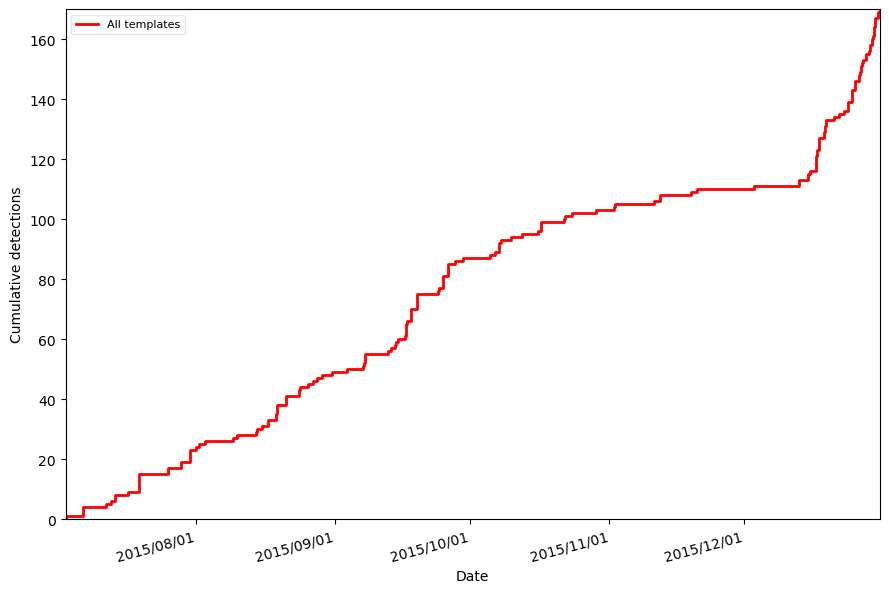

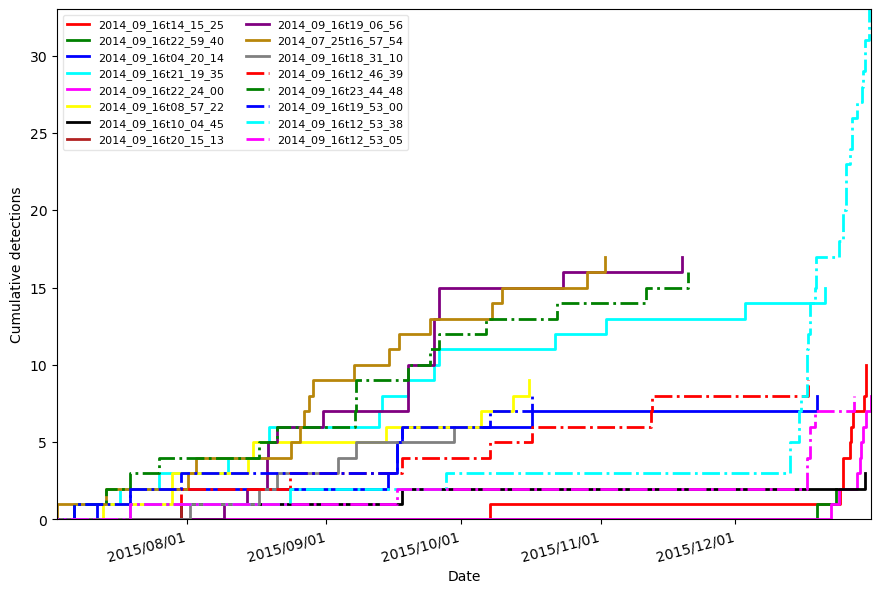

Number of templates: 22
Number of additional detections: 148


In [191]:
party.plot(plot_grouped=True)
party.plot(plot_grouped=False)

print(f'Number of templates: {len(tribe)}')
print(f'Number of additional detections: {len(party)-len(tribe)}')

So, we've added some additional detections, though not a lot. Note that two of the templates (2014-07-17T20:24:49 and the unlocated one we added at 2014-07-25T16:57:55) are matching the most events by themselves. There are also templates that are matching each other, but we don't count those as additional detections since we're requiring that detections have to be at least 1 second apart from each other (`trig_int`).

## Other thoughts...

From here, I think you could take a few detections and try to plot up data from the nodal arrays that were out and make record sections or something. I tried to only search in dates that were around the time of the nodal deployment so you have a good chance of getting a few detections/events at those times. Actually looking at the data is important, and is not something I've done much recently in the scope of this package.

Good luck! Hopefully this is enough to give you a good start.